In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataset import ECGDataset, read_dataset_from_csv, dataset_folder, read_x_from_csv, read_x_from_mat
from sklearn.metrics import accuracy_score
from torchvision import transforms
from utils import smooth_predictions
from tqdm import tqdm

In [2]:
TRAIN = True
DATA_CSV = 'data_147.csv'
DATA_PREFIX = DATA_CSV.split('.')[0]

NUM_OF_CLASS = 3


In [3]:
class ECGModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(ECGModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Apply classifier to every time step
        time_steps = lstm_out.shape[1]
        out = self.classifier(lstm_out.reshape(-1, lstm_out.shape[2]))
        return out.view(-1, time_steps, self.classifier.out_features)
    



In [4]:
if TRAIN:
    # Create Dataset and DataLoader 
    # Modify this based on your need 
    dataset = read_dataset_from_csv(train_csv='data/train/s2_src.csv', label_csv='data/train/s2_lbl.csv')
    # dataset = dataset_folder('./data/train')
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    print(f'Dataset len: {len(dataset)}')

    # Initialize the model
    model = ECGModel(input_dim=1, hidden_dim=128, num_layers=2, num_classes=NUM_OF_CLASS)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    def train(model, dataloader, criterion, optimizer, num_epochs):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 3), labels.view(-1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(dataloader)}')
            torch.save(model.state_dict(), 'ecg_model.pth')

    # Example training call
    num_epochs = 50
    train(model, dataloader, criterion, optimizer, num_epochs)

Dataset len: 77
Epoch 1, Average Loss: 0.9383031487464905
Epoch 2, Average Loss: 0.6951839685440063
Epoch 3, Average Loss: 0.48875986933708193
Epoch 4, Average Loss: 0.3596354603767395
Epoch 5, Average Loss: 0.2789766788482666
Epoch 6, Average Loss: 0.2289922446012497
Epoch 7, Average Loss: 0.19907385110855103
Epoch 8, Average Loss: 0.17843689322471618
Epoch 9, Average Loss: 0.16032934188842773
Epoch 10, Average Loss: 0.14777202606201173
Epoch 11, Average Loss: 0.13971974849700927
Epoch 12, Average Loss: 0.13207057267427444
Epoch 13, Average Loss: 0.1251077726483345
Epoch 14, Average Loss: 0.11911436766386033
Epoch 15, Average Loss: 0.11512878686189651
Epoch 16, Average Loss: 0.10569707006216049
Epoch 17, Average Loss: 0.10557239949703216
Epoch 18, Average Loss: 0.0952610969543457
Epoch 19, Average Loss: 0.0961136668920517
Epoch 20, Average Loss: 0.08986908495426178
Epoch 21, Average Loss: 0.08339415788650513
Epoch 22, Average Loss: 0.08266743421554565
Epoch 23, Average Loss: 0.0758162

In [ ]:
from tqdm import tqdm
model = ECGModel(input_dim=1, hidden_dim=128, num_layers=2, num_classes=NUM_OF_CLASS)
model.load_state_dict(torch.load('ecg_model.pth'))
print("Model loaded")
model.eval() 
# test_dataset = read_dataset_from_csv(train_csv='data/test/s1_src.csv', label_csv='data/test/s1_lbl.csv')
test_dataset = read_x_from_csv(f'data/exp_data/{DATA_CSV}')
# test_dataset = read_x_from_mat('data/exp_data/61b0.mat')
print("Dataset loaded")

test_dataloader = DataLoader(test_dataset, batch_size=16)
def test(model, dataloader):
    all_predictions = []
    all_labels = []
    all_srcs = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 2)  # Get predicted class for each time step
            all_predictions.extend(predicted.numpy().flatten())
            all_labels.extend(labels.numpy().flatten())
            all_srcs.extend(inputs.numpy().flatten())

    return np.array(all_predictions), np.array(all_labels), np.array(all_srcs)

# Run the test
predictions, labels, srcs = test(model, test_dataloader)


smoothed = smooth_predictions(predictions)
accuracy = accuracy_score(labels, predictions)
sm_acc = accuracy_score(labels, smoothed)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Accuracy smoothed: {sm_acc * 100:.2f}%')

Model loaded
Dataset loaded


Testing: 100%|██████████| 400/400 [00:06<00:00, 66.42it/s]


Accuracy: 48.20%
Accuracy smoothed: 47.92%


Text(0.5, 1.0, 'ECG')

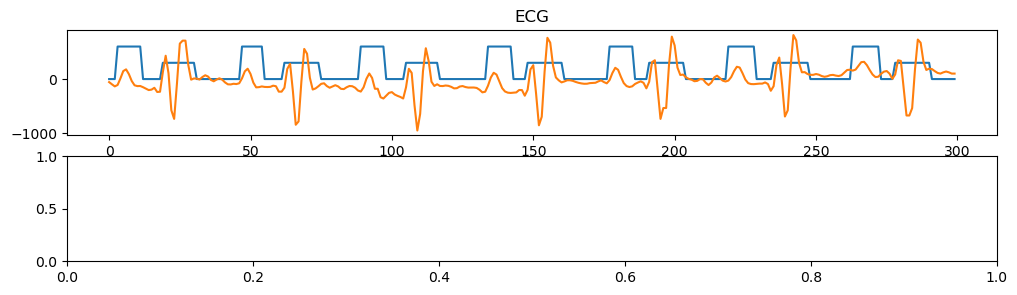

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(12, 3))
start = 3500
end = start + 300
# axs[0].plot(labels[start:end])
# axs[0].set_title('Label')
axs[0].plot(smoothed[start:end]*300)
axs[0].set_title('Prediction')
axs[0].plot(srcs[start:end])
axs[0].set_title('ECG')

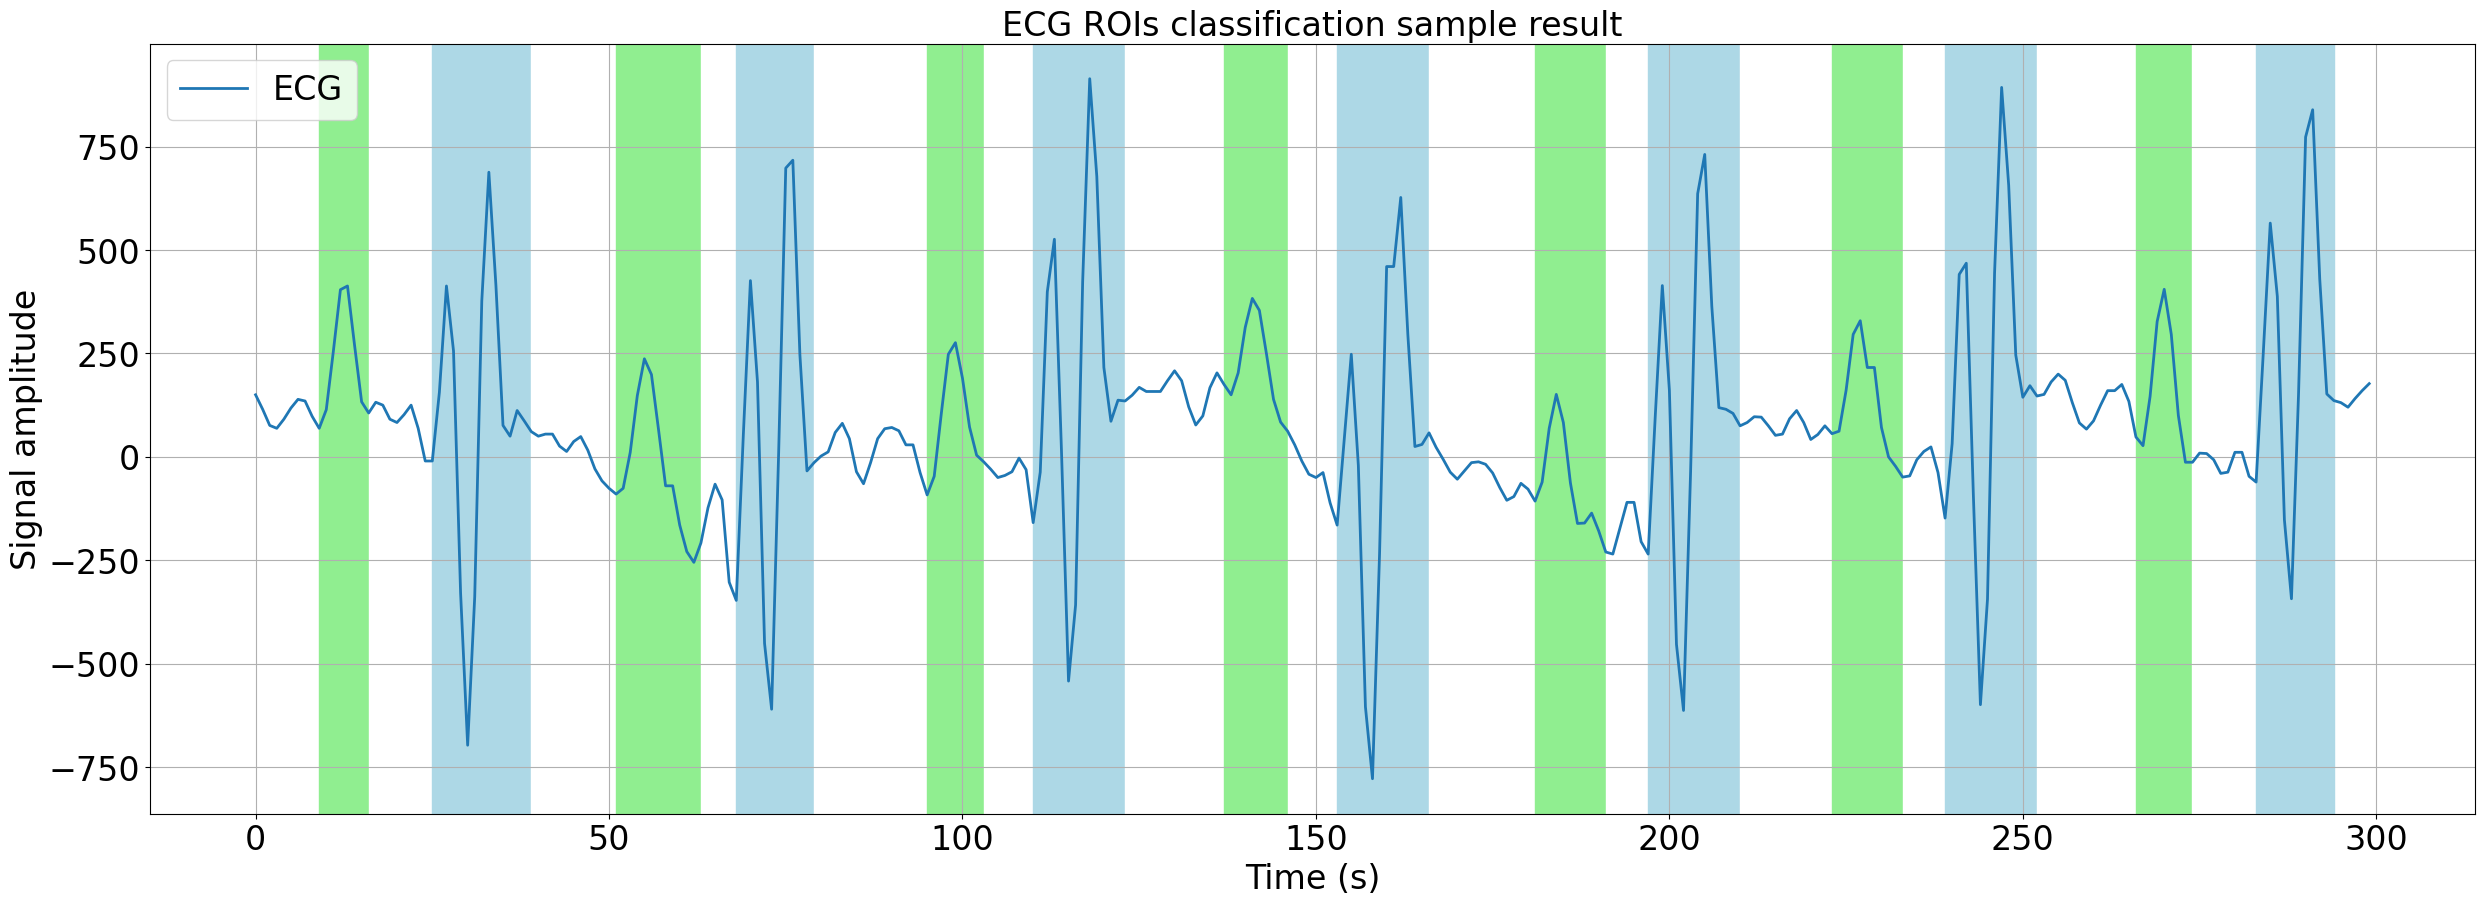

In [ ]:
# Plot the signal
start = 300
end = start + 300
fontsize = 24
signal = srcs[start:end]
labels = smoothed[start:end]
plt.figure(figsize=(30, 10))
plt.plot(signal, label='ECG', linewidth=2)
colors = {0: 'white', 1: 'lightblue', 2: 'lightgreen'}
# Shade each ROI region based on the colors defined
segments = np.where(np.diff(labels) != 0)[0]
for i in range(len(segments)-1):
    
    start_x = segments[i]
    end_x = segments[i+1]
    # start_x = smoothed[start]
    # end_x = smoothed[end]
    plt.axvspan(start_x, end_x, color=colors[labels[end_x]], alpha=1)


# Add labels, grid, and a legend
plt.xlabel('Time (s)', fontsize=fontsize)
plt.ylabel('Signal amplitude', fontsize=fontsize)
plt.title('ECG ROIs classification sample result', fontsize=fontsize)
plt.grid(True)
plt.legend()
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.show()

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 530179


In [9]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
def to_roi_df(labels):
    changes = np.diff(labels, prepend=labels[0])

    # Identify the start and end indices
    starts = np.where(changes != 0)[0]
    ends = np.where(changes != 0)[0][1:]

    # Include the end of the last segment
    ends = np.append(ends, len(labels))

    # Get the wave types
    waves = labels[starts]

    # Create the DataFrame
    df = pd.DataFrame({
        'wave': waves,
        'start_index': starts,
        'end_index': ends - 1
    })

    # Filter out the segments with wave type 0
    df = df[df['wave'] != 0].reset_index(drop=True)

    # Map the wave types to their names
    wave_mapping = {2: 'p', 1: 'qrs'}
    df['wave'] = df['wave'].map(wave_mapping)
    df['duration'] = df['end_index'] - df['start_index']
    return df

def find_peaks_in_segment(segment, wave_type):
    plt.show()
    if wave_type == 'p':
        # For 'p' wave, we expect one peak
        peaks, _ = find_peaks(segment)
        if peaks.size == 0:
            return [np.nan]  # No peak found
        return [peaks[np.argmax(segment[peaks])]]  # Return the location of the highest peak
    elif wave_type == 'qrs':
        # For 'qrs' wave, we expect two peaks: R and J
        peaks, _ = find_peaks(segment)
        
        if peaks.size < 2:
            return [np.nan, np.nan]  # Less than 2 peaks found
        sorted_peaks = peaks[np.argsort(segment[peaks])][::-1]  # Sort peaks by height
        return sorted(sorted_peaks[:2])  # Return the two largest peaks in time order

# Function to get peaks from the DataFrame
def get_peaks_from_roi(df, signal):
    peaks_data = {'wave': [], 'peak1': [], 'peak2': [], 'duration':[]}
    
    for index, row in df.iterrows():
        segment = signal[row['start_index']:row['end_index'] + 1]

        peaks = find_peaks_in_segment(segment, row['wave'])
        print(peaks)
        peaks_data['wave'].append(row['wave'])
        peaks_data['peak1'].append(row['start_index'] + peaks[0] if not np.isnan(peaks[0]) else np.nan)
        print(row['start_index'] + peaks[0] if not np.isnan(peaks[0]) else np.nan)
        peaks_data['peak2'].append(row['start_index'] + peaks[1] if len(peaks) > 1 and not np.isnan(peaks[1]) else np.nan)
        peaks_data['duration'].append(row.duration)

    return pd.DataFrame(peaks_data)



def filter_peaks(df):
    valid_indices = []
    i = 0
    while i < len(df) - 1:
        if (df.iloc[i]['wave'] == 'p' and not np.isnan(df.iloc[i]['peak1']) and
            df.iloc[i + 1]['wave'] == 'qrs' and not np.isnan(df.iloc[i + 1]['peak1']) and not np.isnan(df.iloc[i + 1]['peak2'])):
            valid_indices.extend([i, i + 1])
            i += 2
        else:
            i += 1
    return df.iloc[valid_indices].reset_index(drop=True)

roi_df = to_roi_df(smoothed)

In [10]:
roi_df

,wave,start_index,end_index,duration
0,p,10,17,7
1,qrs,25,38,13
2,p,54,61,7
3,qrs,69,81,12
4,p,97,105,8
...,...,...,...,...
15687,qrs,319506,319517,11
15688,p,319536,319543,7
15689,qrs,319551,319562,11
15690,p,319580,319587,7


In [11]:
peak_df = get_peaks_from_roi(roi_df, srcs)
peak_df = filter_peaks(peak_df)

[3]
13
[2, 7]
27
[2]
56
[1, 7]
70
[2]
99
[1, 7]
113
[2]
141
[2, 7]
157
[3]
184
[2, 8]
199
[2]
227
[2, 7]
242
[2]
270
[2, 8]
284
[3]
313
[1, 7]
327
[3]
355
[1, 7]
370
[3]
399
[2, 7]
413
[3]
441
[1, 8]
455
[2]
484
[1, 7]
499
[3]
527
[2, 7]
542
[3]
570
[1, 7]
585
[2]
612
[2, 7]
628
[2]
656
[2, 7]
671
[2]
698
[2, 8]
713
[2]
741
[2, 7]
757
[2]
784
[2, 7]
800
[2]
827
[1, 6]
842
[2]
870
[3, 9]
885
[2]
913
[1, 7]
928
[8]
957
[2, 7]
971
[2]
999
[2, 7]
1014
[3]
1042
[1, 8]
1056
[2]
1084
[2, 7]
1100
[2]
1128
[3, 8]
1144
[2]
1171
[2, 7]
1187
[2]
1215
[2, 7]
1230
[2]
1257
[2, 7]
1272
[2]
1300
[1, 7]
1315
[3]
1343
[2, 7]
1359
[3]
1387
[1, 7]
1401
[2]
1429
[2, 8]
1444
[3]
1472
[2, 7]
1488
[2]
1515
[1, 7]
1530
[2]
1559
[1, 7]
1573
[2]
1602
[nan, nan]
nan
[3]
1646
[1, 7]
1659
[3]
1689
[1, 8]
1702
[3]
1732
[2, 8]
1746
[3]
1775
[3, 8]
1789
[2]
1818
[3, 8]
1832
[2]
1861
[2, 7]
1876
[3]
1905
[1, 7]
1919
[2]
1948
[2, 8]
1962
[2]
1991
[2, 7]
2005
[2]
2034
[2, 7]
2049
[2]
2077
[2, 7]
2092
[3]
2121
[2, 7]
2135

In [12]:
len(signal)

300

In [13]:
# peak_df.to_csv(f'{DATA_PREFIX}_peaks.csv')
peak_df

,wave,peak1,peak2,duration
0,p,13.0,NaN,7
1,qrs,27.0,32.0,13
2,p,56.0,NaN,7
3,qrs,70.0,76.0,12
4,p,99.0,NaN,8
...,...,...,...,...
15623,qrs,319464.0,319469.0,11
15624,p,319494.0,NaN,9
15625,qrs,319508.0,319514.0,11
15626,p,319539.0,NaN,7


In [14]:
def calculate_intervals(df, sampling_rate=512):
    intervals = {
        'p_peak_index': [],
        'pr_interval': [],
        'pj_interval': [],
        'duration':[]
    }
    
    i = 0
    while i < len(df) - 1:
        if (df.iloc[i]['wave'] == 'p' and not np.isnan(df.iloc[i]['peak1']) and
            df.iloc[i + 1]['wave'] == 'qrs' and not np.isnan(df.iloc[i + 1]['peak1']) and not np.isnan(df.iloc[i + 1]['peak2'])):
            p_peak_index = df.iloc[i]['peak1']
            qrs_peak1 = df.iloc[i + 1]['peak1']
            qrs_peak2 = df.iloc[i + 1]['peak2']
            
            pr_interval = (qrs_peak1 - p_peak_index) / sampling_rate
            pj_interval = (qrs_peak2 - p_peak_index) / sampling_rate
            print(f'({qrs_peak2} - {p_peak_index})/{sampling_rate} = {pj_interval}')
            print(pj_interval)
            
            intervals['p_peak_index'].append(p_peak_index)
            intervals['pr_interval'].append(pr_interval)
            intervals['pj_interval'].append(pj_interval)
            intervals['duration'].append(df.iloc[i].duration)
            
            i += 2
        else:
            i += 1
    
    return pd.DataFrame(intervals)

intervals = calculate_intervals(peak_df)
intervals['p_peak_index'] = intervals['p_peak_index'].astype(int)

(32.0 - 13.0)/512 = 0.037109375
0.037109375
(76.0 - 56.0)/512 = 0.0390625
0.0390625
(119.0 - 99.0)/512 = 0.0390625
0.0390625
(162.0 - 141.0)/512 = 0.041015625
0.041015625
(205.0 - 184.0)/512 = 0.041015625
0.041015625
(247.0 - 227.0)/512 = 0.0390625
0.0390625
(290.0 - 270.0)/512 = 0.0390625
0.0390625
(333.0 - 313.0)/512 = 0.0390625
0.0390625
(376.0 - 355.0)/512 = 0.041015625
0.041015625
(418.0 - 399.0)/512 = 0.037109375
0.037109375
(462.0 - 441.0)/512 = 0.041015625
0.041015625
(505.0 - 484.0)/512 = 0.041015625
0.041015625
(547.0 - 527.0)/512 = 0.0390625
0.0390625
(591.0 - 570.0)/512 = 0.041015625
0.041015625
(633.0 - 612.0)/512 = 0.041015625
0.041015625
(676.0 - 656.0)/512 = 0.0390625
0.0390625
(719.0 - 698.0)/512 = 0.041015625
0.041015625
(762.0 - 741.0)/512 = 0.041015625
0.041015625
(805.0 - 784.0)/512 = 0.041015625
0.041015625
(847.0 - 827.0)/512 = 0.0390625
0.0390625
(891.0 - 870.0)/512 = 0.041015625
0.041015625
(934.0 - 913.0)/512 = 0.041015625
0.041015625
(976.0 - 957.0)/512 = 0.0

In [15]:

intervals.set_index('p_peak_index', inplace=True)
ecg_df = pd.DataFrame({"ECG":srcs, "Label":smoothed})
merged_df = ecg_df.merge(intervals, right_on='p_peak_index', left_index=True, how='left')
merged_df = merged_df.ffill().bfill()
merged_df.to_csv(f'data/intervals/{DATA_PREFIX}_intervals.csv')

In [16]:
p_df = peak_df[peak_df['wave'] == 'p']
p_df['index'] = [int(x) for x in p_df['peak1']]
p_df['ppinterval'] = p_df['peak1'].diff()
p_df

/var/folders/jb/_v1vgtz16n37l32s4fngkj300000gn/T/ipykernel_46649/2023337947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['index'] = [int(x) for x in p_df['peak1']]
/var/folders/jb/_v1vgtz16n37l32s4fngkj300000gn/T/ipykernel_46649/2023337947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['ppinterval'] = p_df['peak1'].diff()


,wave,peak1,peak2,duration,index,ppinterval
0,p,13.0,NaN,7,13,NaN
2,p,56.0,NaN,7,56,43.0
4,p,99.0,NaN,8,99,43.0
6,p,141.0,NaN,7,141,42.0
8,p,184.0,NaN,8,184,43.0
...,...,...,...,...,...,...
15618,p,319360.0,NaN,7,319360,45.0
15620,p,319405.0,NaN,7,319405,45.0
15622,p,319450.0,NaN,8,319450,45.0
15624,p,319494.0,NaN,9,319494,44.0


In [17]:
merged_df = merged_df.merge(p_df[['index', 'ppinterval']], right_on='index', left_index=True, how='left')
merged_df = merged_df.ffill().bfill()

In [19]:
merged_df.to_csv(f"{DATA_PREFIX}_intervals.csv")